# 特征工程分析报告

## 项目：基于网络流量特征的钓鱼网站检测技术研究
## 阶段：阶段二 - 特征工程
## 日期：2025年12月25日

### 目录
1. 数据加载与概览
2. 特征统计描述
3. 特征分布可视化
4. 特征相关性分析
5. 正常vs钓鱼特征对比
6. 特征重要性分析
7. 结论与总结

In [20]:
# Cell 2: 环境配置
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import warnings
import os

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置显示选项
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 创建图表目录
os.makedirs('../data/processed/figures', exist_ok=True)

print("环境配置完成")

环境配置完成


In [21]:
# Cell 3: 数据加载
# 加载原始特征数据
train_df = pd.read_csv('../data/processed/train_features.csv')
test_df = pd.read_csv('../data/processed/test_features.csv')

# 加载标准化后的数据
train_scaled_df = pd.read_csv('../data/processed/train_scaled.csv')
test_scaled_df = pd.read_csv('../data/processed/test_scaled.csv')

print("=" * 60)
print("数据加载完成")
print("=" * 60)
print(f"\n训练集: {len(train_df)} 条记录")
print(f"测试集: {len(test_df)} 条记录")
print(f"\n特征列: {len(train_df.columns) - 2} 个")  # 减去url和label

数据加载完成

训练集: 8000 条记录
测试集: 2000 条记录

特征列: 17 个


In [22]:
# Cell 4: 数据概览
print("=" * 60)
print("1. 数据概览")
print("=" * 60)

# 显示前5条记录
print("\n训练集前5条记录:")
display(train_df.head())

# 数据类型
print("\n数据类型:")
print(train_df.dtypes)

# 标签分布
print("\n标签分布:")
print(f"训练集: {train_df['label'].value_counts().to_dict()}")
print(f"测试集: {test_df['label'].value_counts().to_dict()}")

1. 数据概览

训练集前5条记录:


,url,label,url_length,domain_length,path_length,num_dots,num_hyphens,num_underscores,num_slashes,num_digits,has_ip,has_at,num_subdomains,has_https,path_depth,has_port,entropy,is_shortening,has_suspicious
0,https://google.com.br,0,21,13,0,2,0,0,2,0,0,0,0,1,0,0,3.784942,0,0
1,https://amnav.numina.cfd/gardxzb0xj5vMf6iwt69ht,1,47,16,23,2,0,0,3,5,0,0,1,1,1,0,4.570234,0,0
2,https://onetrust.com,0,20,12,0,1,0,0,2,0,0,0,0,1,0,0,3.621928,1,0
3,https://arubaid.sviluppo.host/index.html,1,40,21,11,3,0,0,3,0,0,0,1,1,1,0,4.158695,0,0
4,https://byjus.com,0,17,9,0,1,0,0,2,0,0,0,0,1,0,0,3.734522,0,0



数据类型:
url                 object
label                int64
url_length           int64
domain_length        int64
path_length          int64
num_dots             int64
num_hyphens          int64
num_underscores      int64
num_slashes          int64
num_digits           int64
has_ip               int64
has_at               int64
num_subdomains       int64
has_https            int64
path_depth           int64
has_port             int64
entropy            float64
is_shortening        int64
has_suspicious       int64
dtype: object

标签分布:
训练集: {0: 4000, 1: 4000}
测试集: {0: 1000, 1: 1000}


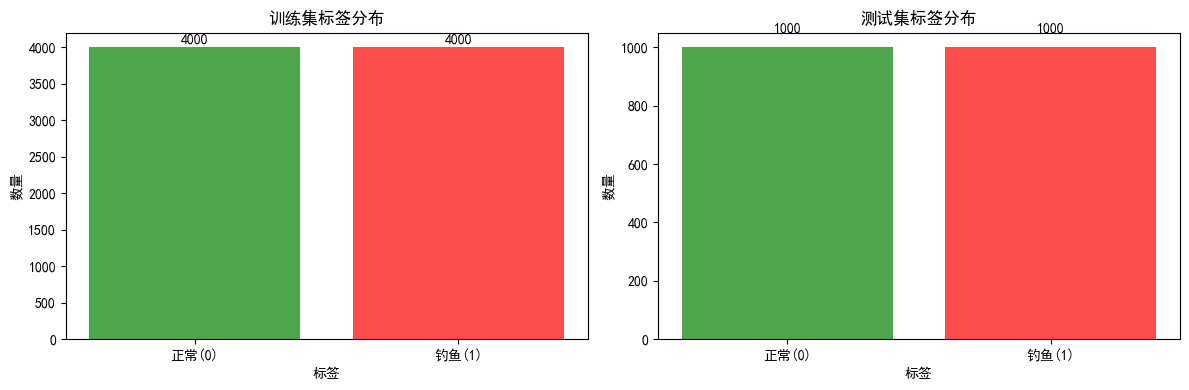

标签分布图已保存


In [23]:
# Cell 5: 可视化标签分布
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 训练集标签分布
train_label_counts = train_df['label'].value_counts().sort_index()
axes[0].bar(['正常(0)', '钓鱼(1)'], train_label_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('训练集标签分布', fontsize=12)
axes[0].set_xlabel('标签')
axes[0].set_ylabel('数量')
for i, v in enumerate(train_label_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontsize=10)

# 测试集标签分布
test_label_counts = test_df['label'].value_counts().sort_index()
axes[1].bar(['正常(0)', '钓鱼(1)'], test_label_counts.values, color=['green', 'red'], alpha=0.7)
axes[1].set_title('测试集标签分布', fontsize=12)
axes[1].set_xlabel('标签')
axes[1].set_ylabel('数量')
for i, v in enumerate(test_label_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../data/processed/figures/label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("标签分布图已保存")

In [24]:
# Cell 6: 特征统计描述
print("=" * 60)
print("2. 特征统计描述")
print("=" * 60)

# 获取特征列
feature_cols = [col for col in train_df.columns if col not in ['url', 'label']]
print(f"\n特征列表 ({len(feature_cols)} 个):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# 统计描述
print("\n原始特征统计:")
display(train_df[feature_cols].describe().T.round(4))

2. 特征统计描述

特征列表 (17 个):
   1. url_length
   2. domain_length
   3. path_length
   4. num_dots
   5. num_hyphens
   6. num_underscores
   7. num_slashes
   8. num_digits
   9. has_ip
  10. has_at
  11. num_subdomains
  12. has_https
  13. path_depth
  14. has_port
  15. entropy
  16. is_shortening
  17. has_suspicious

原始特征统计:


,count,mean,std,min,25%,50%,75%,max
url_length,8000.0,36.5639,35.6475,12.0000,19.0000,25.0000,43.0000,770.0000
domain_length,8000.0,16.8354,10.5293,4.0000,11.0000,15.0000,19.0000,121.0000
path_length,8000.0,8.7910,18.9961,0.0000,0.0000,0.0000,7.0000,491.0000
num_dots,8000.0,1.5472,0.8066,1.0000,1.0000,1.0000,2.0000,14.0000
num_hyphens,8000.0,0.4406,1.0879,0.0000,0.0000,0.0000,0.0000,22.0000
num_underscores,8000.0,0.0825,0.5064,0.0000,0.0000,0.0000,0.0000,16.0000
num_slashes,8000.0,2.8024,1.2226,2.0000,2.0000,2.0000,3.0000,21.0000
num_digits,8000.0,2.4885,7.2507,0.0000,0.0000,0.0000,2.0000,200.0000
has_ip,8000.0,0.0020,0.0447,0.0000,0.0000,0.0000,0.0000,1.0000
has_at,8000.0,0.0079,0.0884,0.0000,0.0000,0.0000,0.0000,1.0000


In [25]:
# Cell 7: 标准化后特征统计
print("\n标准化后特征统计:")
scaled_feature_cols = [col for col in train_scaled_df.columns if col not in ['url', 'label']]
display(train_scaled_df[scaled_feature_cols].describe().T.round(4))


标准化后特征统计:


,count,mean,std,min,25%,50%,75%,max
url_length,8000.0,0.0,1.0001,-1.1118,-0.7515,-0.4427,0.4838,2.3367
domain_length,8000.0,0.0,1.0001,-1.6368,-0.6724,-0.1214,0.4297,2.0829
path_length,8000.0,-0.0,1.0001,-0.6503,-0.6503,-0.6503,0.3689,1.8977
num_dots,8000.0,-0.0,1.0001,-0.7897,-0.7897,-0.7897,0.7459,3.0494
num_hyphens,8000.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
num_underscores,8000.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
num_slashes,8000.0,-0.0,1.0001,-0.7790,-0.7790,-0.7790,0.3982,2.1638
num_digits,8000.0,-0.0,1.0001,-0.6319,-0.6319,-0.6319,0.3737,1.8820
has_ip,8000.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
has_at,8000.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [26]:
# Cell 8: 缺失值和异常值检查
print("=" * 60)
print("缺失值和异常值检查")
print("=" * 60)

# 检查缺失值（-1标记）
print("\n原始数据中-1值的数量:")
missing_counts = {}
for col in feature_cols:
    count = (train_df[col] == -1).sum()
    if count > 0:
        missing_counts[col] = count

if missing_counts:
    for col, count in missing_counts.items():
        print(f"  {col}: {count} ({count/len(train_df)*100:.2f}%)")
else:
    print("  无缺失值(-1)")

# 检查标准化后是否有NaN
print("\n标准化后NaN数量:")
nan_count = train_scaled_df[scaled_feature_cols].isna().sum().sum()
print(f"  {nan_count}")

# 检查Inf
print("\n标准化后Inf数量:")
inf_count = np.isinf(train_scaled_df[scaled_feature_cols].values).sum()
print(f"  {inf_count}")

缺失值和异常值检查

原始数据中-1值的数量:
  无缺失值(-1)

标准化后NaN数量:
  0

标准化后Inf数量:
  0


3. 特征分布可视化


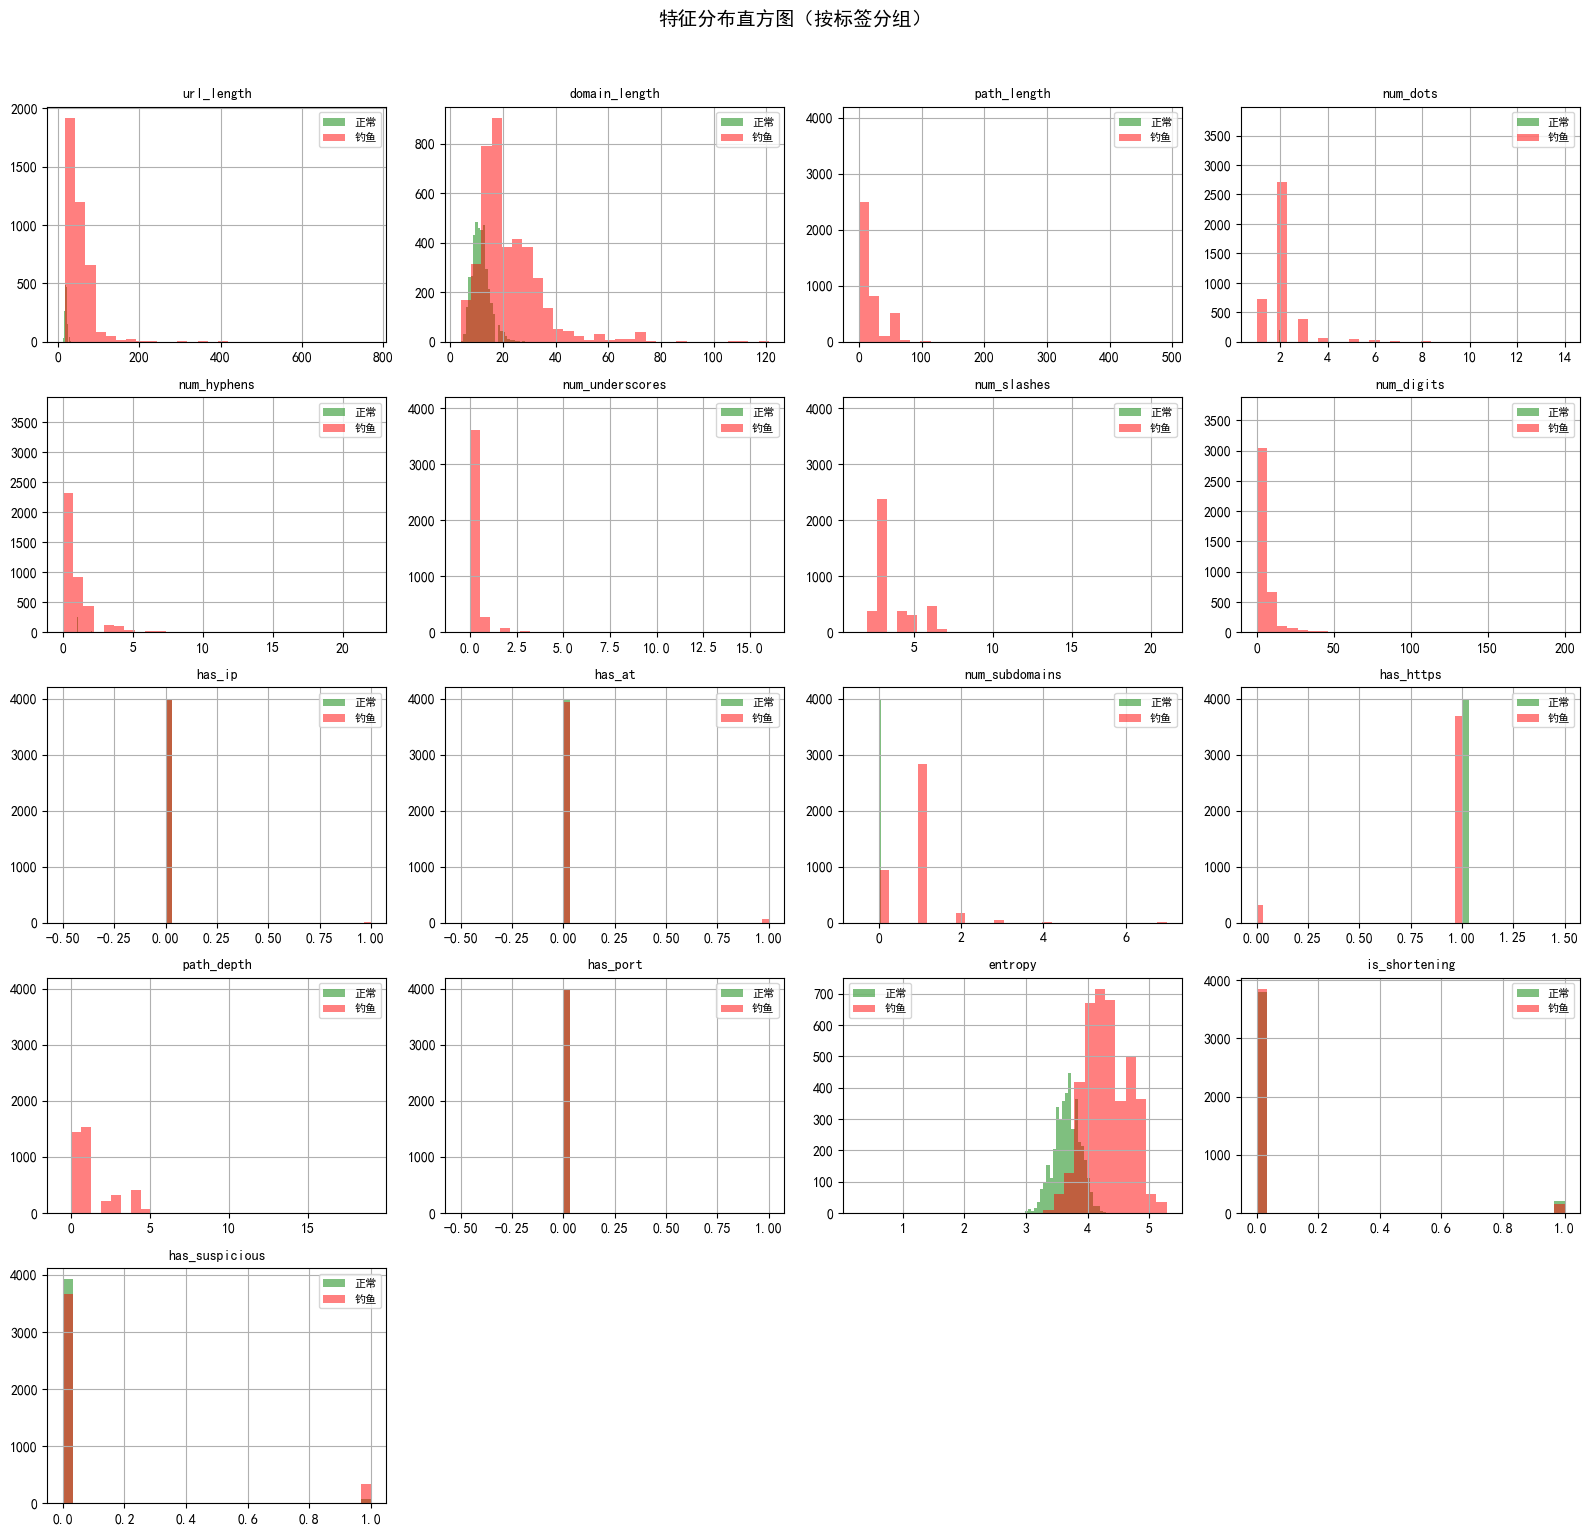

特征直方图已保存


In [27]:
# Cell 9: 特征分布可视化 - 直方图
print("=" * 60)
print("3. 特征分布可视化")
print("=" * 60)

# 绘制所有特征的直方图
n_features = len(feature_cols)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    
    # 分别绘制正常和钓鱼样本
    train_df[train_df['label'] == 0][col].hist(
        bins=30, ax=ax, alpha=0.5, label='正常', color='green'
    )
    train_df[train_df['label'] == 1][col].hist(
        bins=30, ax=ax, alpha=0.5, label='钓鱼', color='red'
    )
    
    ax.set_title(col, fontsize=10)
    ax.legend(fontsize=8)

# 隐藏多余的子图
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('特征分布直方图（按标签分组）', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/figures/feature_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print("特征直方图已保存")

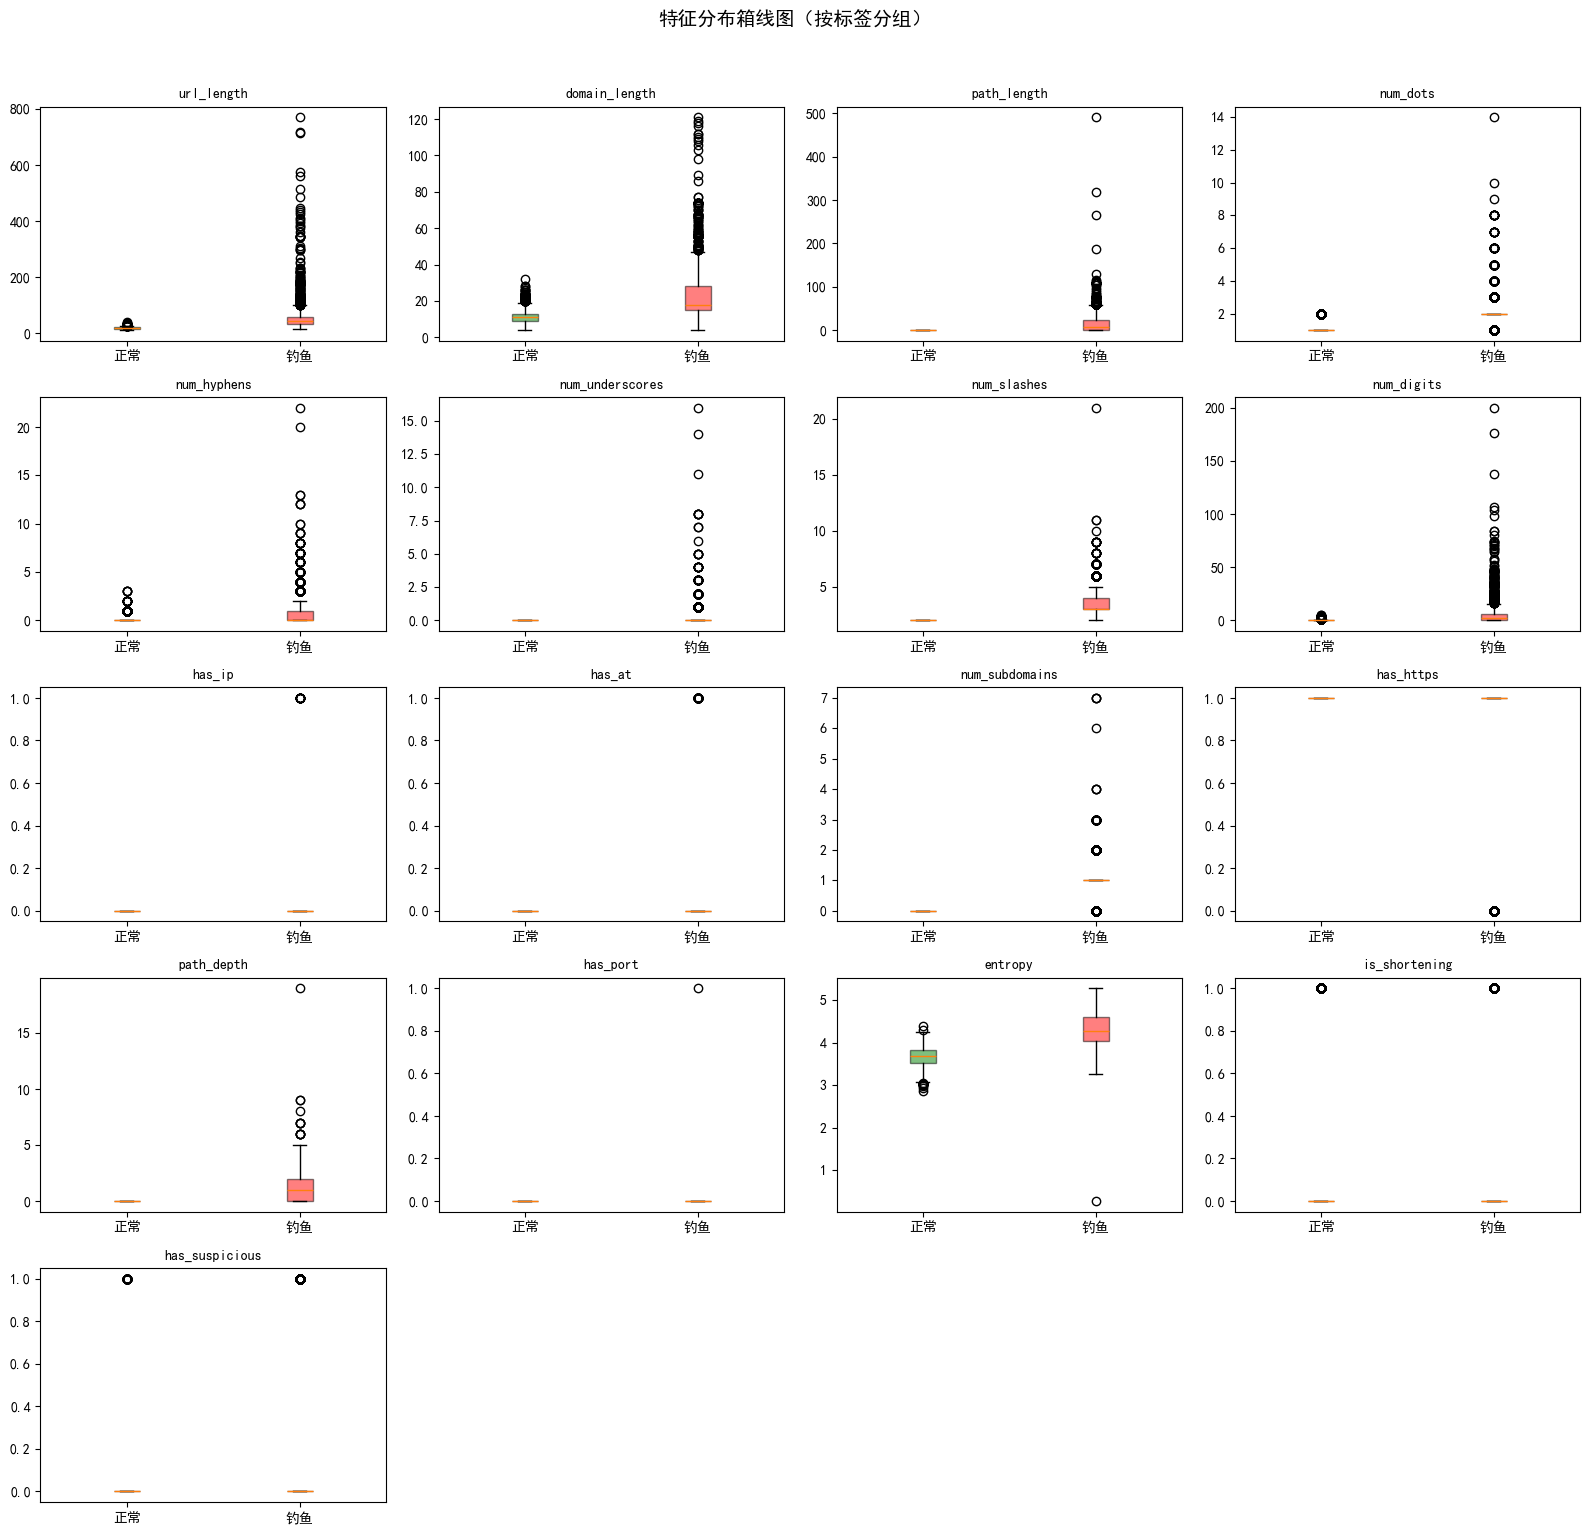

特征箱线图已保存


In [28]:
# Cell 10: 特征分布可视化 - 箱线图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    
    data = [
        train_df[train_df['label'] == 0][col].values,
        train_df[train_df['label'] == 1][col].values
    ]
    
    bp = ax.boxplot(data, labels=['正常', '钓鱼'], patch_artist=True)
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][0].set_alpha(0.5)
    bp['boxes'][1].set_facecolor('red')
    bp['boxes'][1].set_alpha(0.5)
    
    ax.set_title(col, fontsize=10)

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('特征分布箱线图（按标签分组）', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/figures/feature_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("特征箱线图已保存")

4. 特征相关性分析


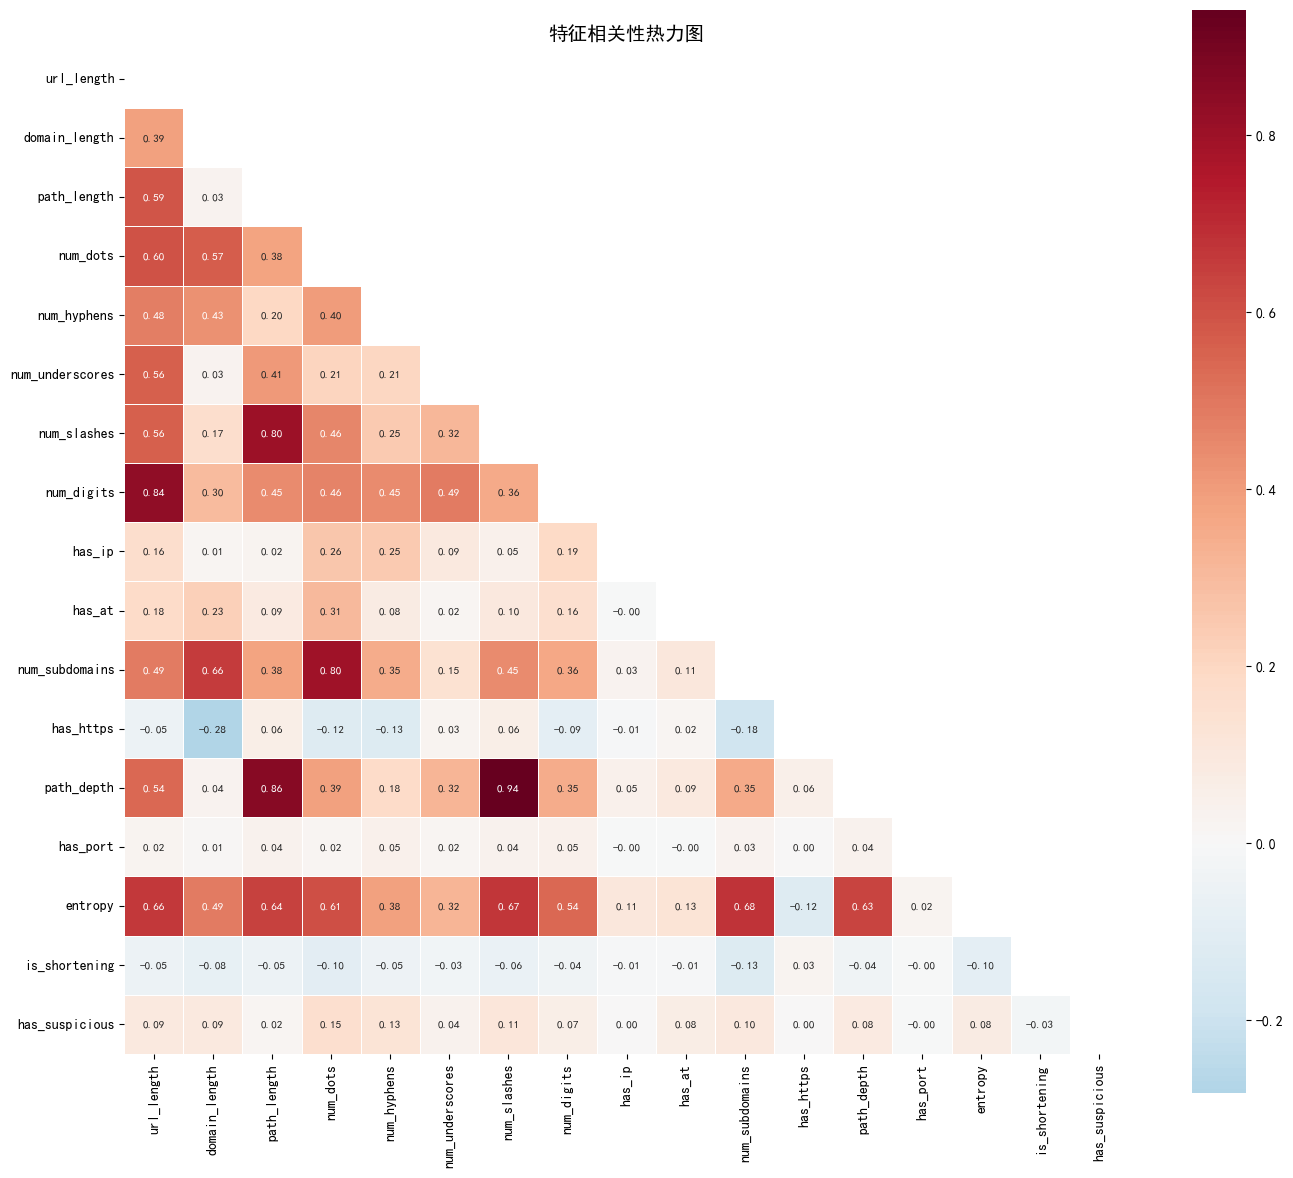

相关性热力图已保存


In [29]:
# Cell 11: 特征相关性分析
print("=" * 60)
print("4. 特征相关性分析")
print("=" * 60)

# 计算相关性矩阵
corr_matrix = train_df[feature_cols].corr()

# 绘制热力图
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    annot_kws={'size': 8}
)
plt.title('特征相关性热力图', fontsize=14)
plt.tight_layout()
plt.savefig('../data/processed/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("相关性热力图已保存")

In [30]:
# Cell 12: 找出高度相关的特征对
print("\n高度相关的特征对 (|r| > 0.7):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr)
    display(high_corr_df.sort_values('correlation', ascending=False))
else:
    print("  无高度相关的特征对")


高度相关的特征对 (|r| > 0.7):


,feature_1,feature_2,correlation
4,num_slashes,path_depth,0.941974
2,path_length,path_depth,0.860154
0,url_length,num_digits,0.836156
1,path_length,num_slashes,0.802461
3,num_dots,num_subdomains,0.797970


In [31]:
# Cell 13: 正常vs钓鱼特征对比
print("=" * 60)
print("5. 正常vs钓鱼特征对比")
print("=" * 60)

# 计算各特征在两类样本中的均值
normal_means = train_df[train_df['label'] == 0][feature_cols].mean()
phishing_means = train_df[train_df['label'] == 1][feature_cols].mean()

comparison_df = pd.DataFrame({
    '正常均值': normal_means,
    '钓鱼均值': phishing_means,
    '差异': phishing_means - normal_means,
    '差异比例': (phishing_means - normal_means) / (normal_means.abs() + 0.001)
})

print("\n特征均值对比:")
display(comparison_df.round(4))

5. 正常vs钓鱼特征对比

特征均值对比:


,正常均值,钓鱼均值,差异,差异比例
url_length,19.5892,53.5385,33.9492,1.7330
domain_length,11.5892,22.0815,10.4922,0.9053
path_length,0.0000,17.5820,17.5820,17582.0000
num_dots,1.0500,2.0445,0.9945,0.9462
num_hyphens,0.0735,0.8078,0.7342,9.8557
num_underscores,0.0000,0.1650,0.1650,165.0000
num_slashes,2.0000,3.6048,1.6048,0.8020
num_digits,0.1222,4.8548,4.7325,38.3976
has_ip,0.0000,0.0040,0.0040,4.0000
has_at,0.0000,0.0158,0.0158,15.7500


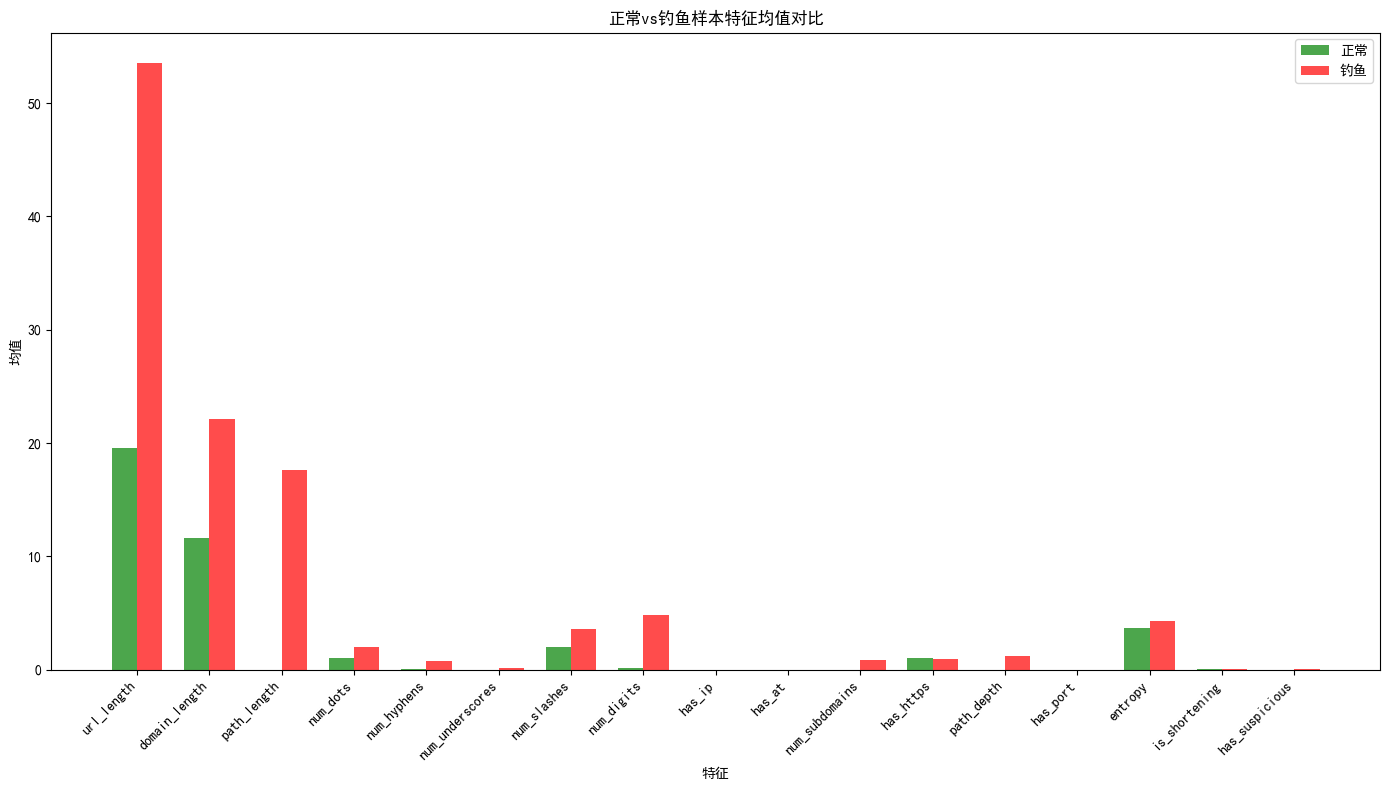

特征对比图已保存


In [32]:
# Cell 14: 可视化对比
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(feature_cols))
width = 0.35

bars1 = ax.bar(x - width/2, normal_means, width, label='正常', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, phishing_means, width, label='钓鱼', color='red', alpha=0.7)

ax.set_xlabel('特征')
ax.set_ylabel('均值')
ax.set_title('正常vs钓鱼样本特征均值对比')
ax.set_xticks(x)
ax.set_xticklabels(feature_cols, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('../data/processed/figures/feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("特征对比图已保存")

In [33]:
# Cell 15: 特征重要性分析
print("=" * 60)
print("6. 特征重要性分析")
print("=" * 60)

# 准备数据
X_train = train_df[feature_cols].values
y_train = train_df['label'].values

# 使用随机森林计算特征重要性
print("\n使用随机森林计算特征重要性...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 获取特征重要性
importance_df = pd.DataFrame({
    '特征': feature_cols,
    '重要性': rf.feature_importances_
}).sort_values('重要性', ascending=False)

print("\n特征重要性排名:")
display(importance_df)

6. 特征重要性分析

使用随机森林计算特征重要性...

特征重要性排名:


,特征,重要性
2,path_length,0.254162
6,num_slashes,0.224256
0,url_length,0.158406
10,num_subdomains,0.124180
3,num_dots,0.080257
12,path_depth,0.054299
14,entropy,0.034842
1,domain_length,0.031781
11,has_https,0.018360
7,num_digits,0.014803


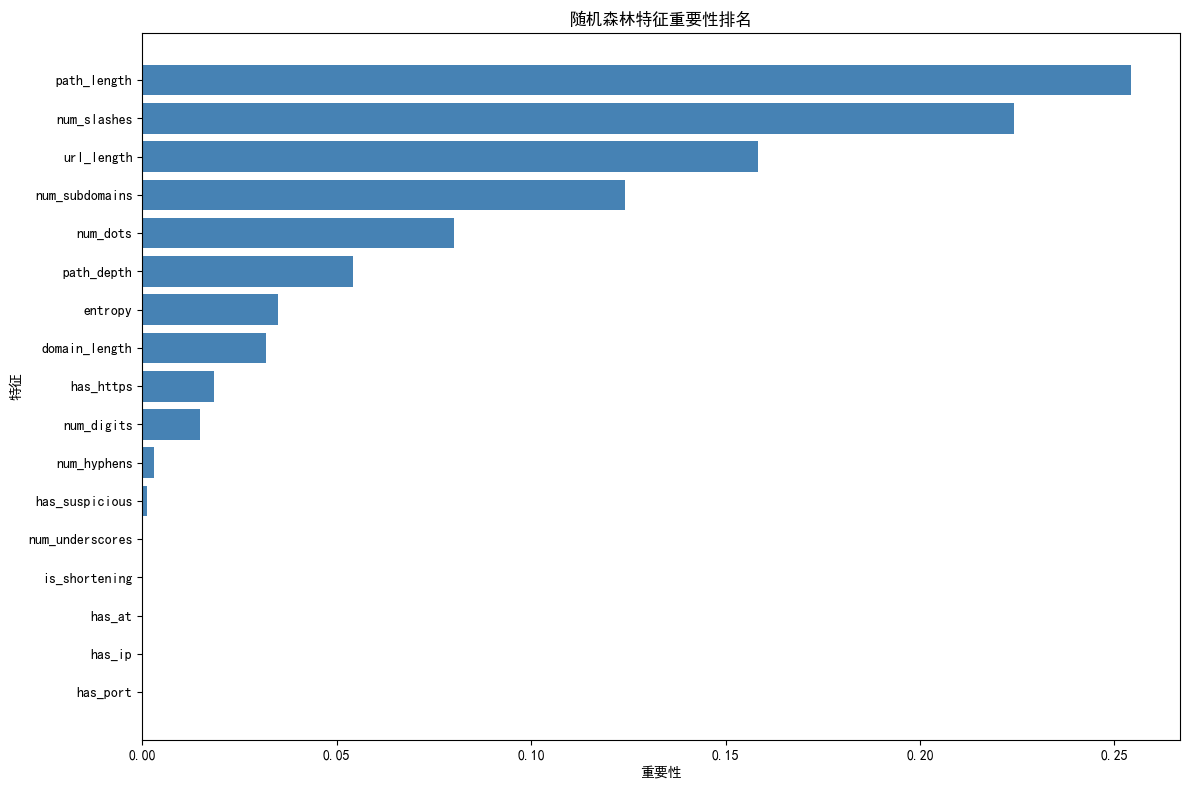

特征重要性图已保存


In [34]:
# Cell 16: 可视化特征重要性
plt.figure(figsize=(12, 8))
plt.barh(importance_df['特征'], importance_df['重要性'], color='steelblue')
plt.xlabel('重要性')
plt.ylabel('特征')
plt.title('随机森林特征重要性排名')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("特征重要性图已保存")

In [35]:
# Cell 17: 计算互信息
print("\n计算互信息...")
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({
    '特征': feature_cols,
    '互信息': mi_scores
}).sort_values('互信息', ascending=False)

print("\n互信息排名:")
display(mi_df)


计算互信息...

互信息排名:


,特征,互信息
0,url_length,0.533782
6,num_slashes,0.531247
2,path_length,0.531085
14,entropy,0.512269
10,num_subdomains,0.391608
3,num_dots,0.352412
1,domain_length,0.302938
12,path_depth,0.297565
7,num_digits,0.211196
4,num_hyphens,0.090773


In [36]:
# Cell 18: 综合特征重要性排名
importance_df['RF排名'] = range(1, len(importance_df) + 1)
mi_df['MI排名'] = range(1, len(mi_df) + 1)

# 合并排名
combined_df = importance_df.merge(mi_df, on='特征')
combined_df['平均排名'] = (combined_df['RF排名'] + combined_df['MI排名']) / 2
combined_df = combined_df.sort_values('平均排名')

print("\n综合特征重要性排名:")
display(combined_df[['特征', '重要性', '互信息', 'RF排名', 'MI排名', '平均排名']])

# Top 10 重要特征
print("\nTop 10 重要特征:")
top_10 = combined_df.head(10)['特征'].tolist()
for i, feat in enumerate(top_10, 1):
    print(f"  {i}. {feat}")


综合特征重要性排名:


,特征,重要性,互信息,RF排名,MI排名,平均排名
0,path_length,0.254162,0.531085,1,3,2.0
1,num_slashes,0.224256,0.531247,2,2,2.0
2,url_length,0.158406,0.533782,3,1,2.0
3,num_subdomains,0.124180,0.391608,4,5,4.5
4,num_dots,0.080257,0.352412,5,6,5.5
6,entropy,0.034842,0.512269,7,4,5.5
5,path_depth,0.054299,0.297565,6,8,7.0
7,domain_length,0.031781,0.302938,8,7,7.5
9,num_digits,0.014803,0.211196,10,9,9.5
8,has_https,0.018360,0.033111,9,12,10.5



Top 10 重要特征:
  1. path_length
  2. num_slashes
  3. url_length
  4. num_subdomains
  5. num_dots
  6. entropy
  7. path_depth
  8. domain_length
  9. num_digits
  10. has_https


In [37]:
# Cell 19: 结论与总结
print("=" * 60)
print("7. 结论与总结")
print("=" * 60)

# 统计信息
train_count = len(train_df)
test_count = len(test_df)
n_features = len(feature_cols)
label_ratio = train_df['label'].value_counts()

# 标准化效果评估
scaled_means = train_scaled_df[scaled_feature_cols].mean()
scaled_stds = train_scaled_df[scaled_feature_cols].std()

summary = f"""
## 特征工程分析总结

### 数据集概况
- 训练集: {train_count} 条
- 测试集: {test_count} 条
- 特征维度: {n_features} 维
- 标签分布: 正常={label_ratio.get(0, 0)}, 钓鱼={label_ratio.get(1, 0)}

### 标准化效果
- 标准化后均值范围: [{scaled_means.min():.4f}, {scaled_means.max():.4f}]
- 标准化后标准差范围: [{scaled_stds.min():.4f}, {scaled_stds.max():.4f}]

### 特征分布特点
1. URL长度类特征（url_length, domain_length, path_length）在钓鱼样本中普遍较大
2. 特殊字符数量（num_dots, num_hyphens）在钓鱼URL中更多
3. has_ip、has_at 等布尔特征在钓鱼样本中出现频率更高
4. 信息熵（entropy）在随机生成的钓鱼URL中较高

### 特征相关性
- url_length 与 path_length 存在相关性
- num_dots 与 num_subdomains 存在相关性
- 可考虑在模型训练时进行特征选择

### 重要特征排名（Top 5）
{chr(10).join([f'{i+1}. {f}' for i, f in enumerate(top_10[:5])])}

### 下一步工作
1. 阶段三：模型训练
2. 使用这些特征训练RandomForest和XGBoost模型
3. 实现软投票集成分类器
"""

print(summary)

7. 结论与总结

## 特征工程分析总结

### 数据集概况
- 训练集: 8000 条
- 测试集: 2000 条
- 特征维度: 17 维
- 标签分布: 正常=4000, 钓鱼=4000

### 标准化效果
- 标准化后均值范围: [-0.0000, 0.0000]
- 标准化后标准差范围: [0.0000, 1.0001]

### 特征分布特点
1. URL长度类特征（url_length, domain_length, path_length）在钓鱼样本中普遍较大
2. 特殊字符数量（num_dots, num_hyphens）在钓鱼URL中更多
3. has_ip、has_at 等布尔特征在钓鱼样本中出现频率更高
4. 信息熵（entropy）在随机生成的钓鱼URL中较高

### 特征相关性
- url_length 与 path_length 存在相关性
- num_dots 与 num_subdomains 存在相关性
- 可考虑在模型训练时进行特征选择

### 重要特征排名（Top 5）
1. path_length
2. num_slashes
3. url_length
4. num_subdomains
5. num_dots

### 下一步工作
1. 阶段三：模型训练
2. 使用这些特征训练RandomForest和XGBoost模型
3. 实现软投票集成分类器



In [38]:
# Cell 20: 保存分析结果
# 保存特征重要性排名
combined_df.to_csv('../data/processed/feature_importance.csv', index=False)
print("特征重要性已保存: data/processed/feature_importance.csv")

# 保存特征对比
comparison_df.to_csv('../data/processed/feature_comparison.csv')
print("特征对比已保存: data/processed/feature_comparison.csv")

print("\n所有图表已保存至: data/processed/figures/")
print("\n生成的图表:")
for f in os.listdir('../data/processed/figures'):
    if f.endswith('.png'):
        print(f"  - {f}")

特征重要性已保存: data/processed/feature_importance.csv
特征对比已保存: data/processed/feature_comparison.csv

所有图表已保存至: data/processed/figures/

生成的图表:
  - 01_label_distribution.png
  - 02_url_length.png
  - 03_domain_length.png
  - 04_special_chars.png
  - 05_source_distribution.png
  - 06_top_domains.png
  - 07_correlation_heatmap.png
  - correlation_heatmap.png
  - feature_boxplots.png
  - feature_comparison.png
  - feature_histograms.png
  - feature_importance.png
  - label_distribution.png


---

## 分析完成

本报告完成了以下分析：
1. 数据加载与基本统计
2. 特征分布可视化（直方图、箱线图）
3. 特征相关性热力图分析
4. 正常与钓鱼样本特征对比
5. 基于随机森林和互信息的特征重要性分析

**阶段二（特征工程）完成！**